# Hodgkin-Huxley Model

In [15]:
import itertools
import functools
import numpy as np
import matplotlib.pyplot as plt

from scipy import integrate as scipy_integrate

## Math

In [2]:
C_m = 1.0
g_Na, g_K, g_L = 120.0, 36.0, 0.3
E_Na, E_K, E_L = 50.0, -77.0, -54.387


def alpha_n(V):
    return 0.01 * (V + 55.0) / (1.0 - np.exp(-0.1 * (V + 55.0)))


def beta_n(V):
    return 0.125 * np.exp(-0.0125 * (V + 65))


def alpha_m(V):
    return 0.1 * (V + 40.0) / (1.0 - np.exp(-0.1 * (V + 40.0)))


def beta_m(V):
    return 4.0 * np.exp(-0.0556 * (V + 65.0))


def alpha_h(V):
    return 0.07 * np.exp(-0.05 * (V + 65.0))


def beta_h(V):
    return 1.0 / (1.0 + np.exp(-0.1 * (V + 35.0)))


def I_Na(V, n, m, h):
    return g_Na * m ** 3 * h * (V - E_Na)


def I_K(V, n, m, h):
    return g_K  * n ** 4 * (V - E_K)


def I_L(V, n, m, h):
    return g_L * (V - E_L)


def dy_dt(y, t, I):
    dV_dt = (I(t) - I_Na(*y) - I_K(*y) - I_L(*y)) / C_m
    
    V, n, m, h = y
    dn_dt = alpha_n(V) * (1.0 - n) - beta_n(V) * n
    dm_dt = alpha_m(V) * (1.0 - m) - beta_m(V) * m
    dh_dt = alpha_h(V) * (1.0 - h) - beta_h(V) * h

    return dV_dt, dn_dt, dm_dt, dh_dt

## Simulation 1

In [3]:
TIMES = (30, 50, 90, 100)
AS = (8, 15, 32, 47)
TIME_GAP, A_GAP = 50, 0
assert len(TIMES) == len(AS)


def add_gaps(seq, value):
    values = list(itertools.chain.from_iterable(zip([value] * len(seq), seq)))
    values.append(value)  # Finish gap.
    return np.array(values)


time_blocks = add_gaps(TIMES, TIME_GAP)
a_blocks = add_gaps(AS, A_GAP)
time_blocks, a_blocks

(array([ 50,  30,  50,  50,  50,  90,  50, 100,  50]),
 array([ 0,  8,  0, 15,  0, 32,  0, 47,  0]))

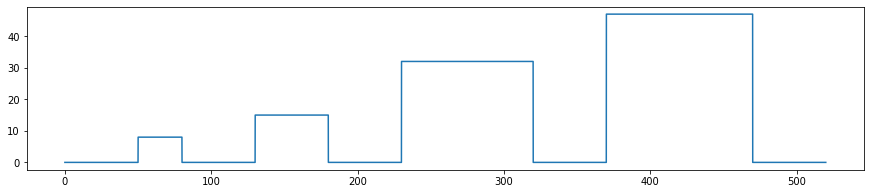

In [4]:
def I1(t):
    for block_t, block_a in zip(time_blocks, a_blocks):
        if t < block_t:
            return block_a
        
        t -= block_t
    
    return A_GAP


time_limit1 = sum(time_blocks)
t = np.arange(0.0, time_limit1, 1e-3)
plt.figure(figsize=(15, 3))
plt.plot(t, list(map(I1, t)));

In [5]:
Y_INITS = (-65, 0.32, 0.05, 0.6)
y = scipy_integrate.odeint(
    func=dy_dt,
    y0=Y_INITS,
    t=t,
    args=(I1,),
).T
y.shape

(4, 520000)

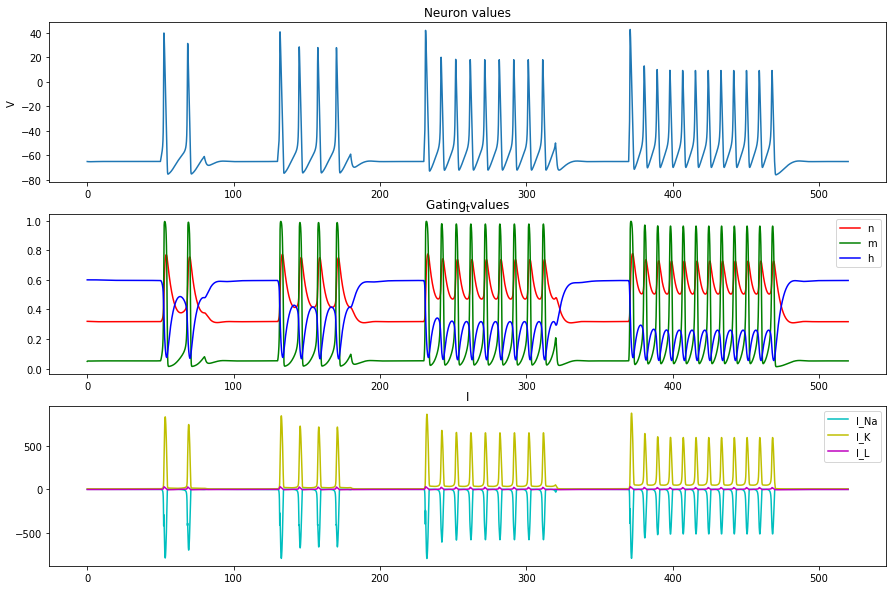

In [6]:
def plot(t, y):
    plt.figure(figsize=(15, 10))
    V, n, m, h = y

    plt.subplot(3, 1, 1)
    plt.xlabel('t')
    plt.ylabel('V')
    plt.title('Neuron values')
    plt.plot(t, V)

    plt.subplot(3, 1, 2)
    plt.title('Gating values')
    plt.plot(t, n, 'r', label='n')
    plt.plot(t, m, 'g', label='m')
    plt.plot(t, h, 'b', label='h')
    plt.legend(loc='upper right')

    plt.subplot(3, 1, 3)
    plt.title('I')
    plt.plot(t, I_Na(*y), 'c', label='I_Na')
    plt.plot(t, I_K(*y), 'y', label='I_K')
    plt.plot(t, I_L(*y), 'm', label='I_L')
    plt.legend(loc='upper right')


plot(t, y)

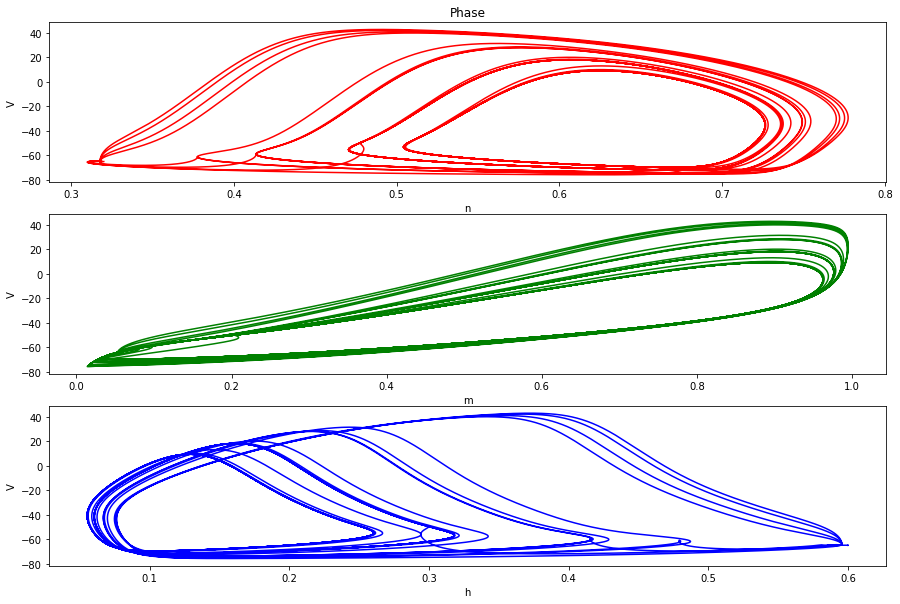

In [7]:
def plot_phase(V, n, m, h):
    plt.figure(figsize=(15, 10))

    plt.subplot(3, 1, 1)
    plt.title('Phase')
    plt.xlabel('n')
    plt.ylabel('V')
    plt.plot(n, V, 'r')

    plt.subplot(3, 1, 2)
    plt.xlabel('m')
    plt.ylabel('V')
    plt.plot(m, V, 'g')
             
    plt.subplot(3, 1, 3)
    plt.xlabel('h')
    plt.ylabel('V')
    plt.plot(h, V, 'b')


plot_phase(*y)

Printing neuron values for times: [0, 130]


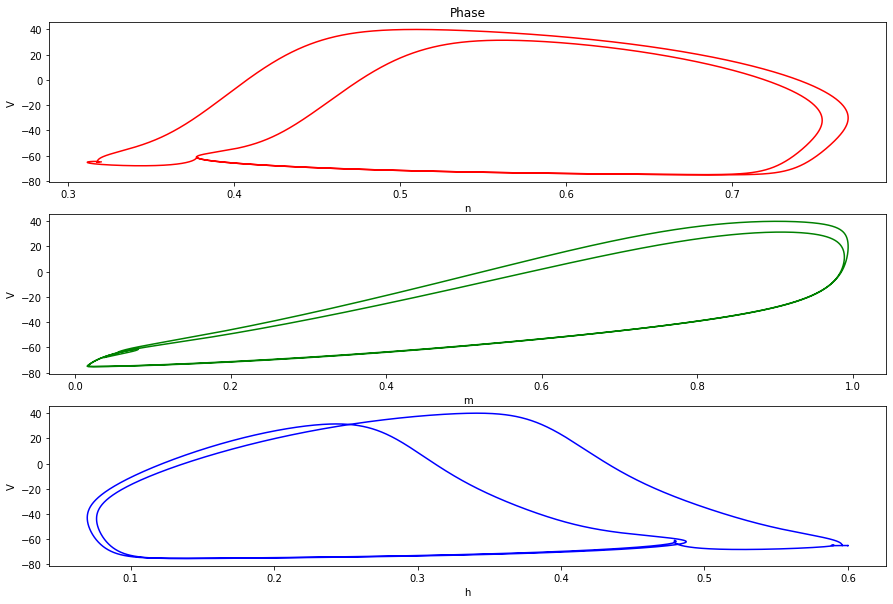

In [8]:
def plot_phase_at_index(index):
    left_t = time_blocks[:2 * index].sum()
    right_t = time_blocks[:2 * index + 3].sum()
    span = (t >= left_t) & (t < right_t)
    y_span = y[:, span]
    print('Printing neuron values for times: [{}, {}]'.format(left_t, right_t))
    plot_phase(*y_span)


plot_phase_at_index(0)

Printing neuron values for times: [80, 230]


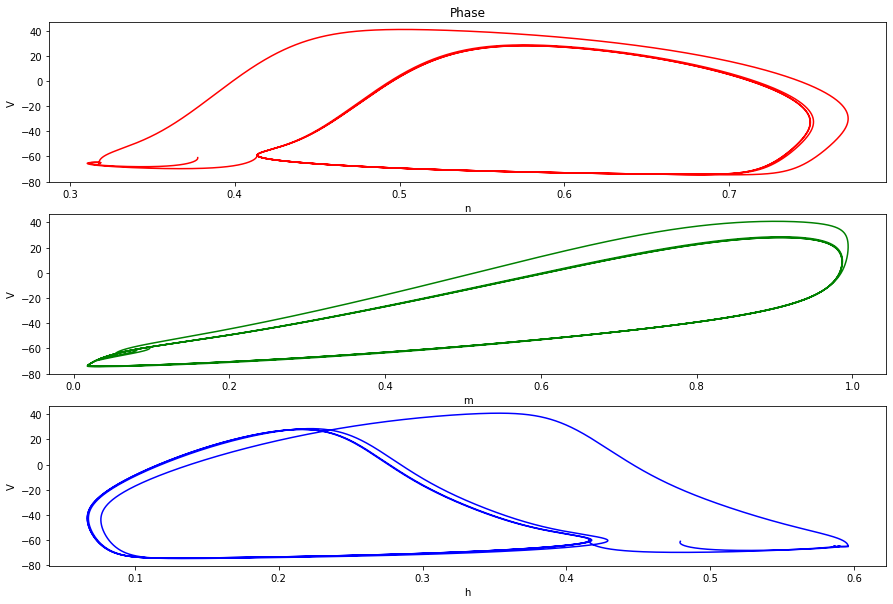

In [9]:
plot_phase_at_index(1)

Printing neuron values for times: [180, 370]


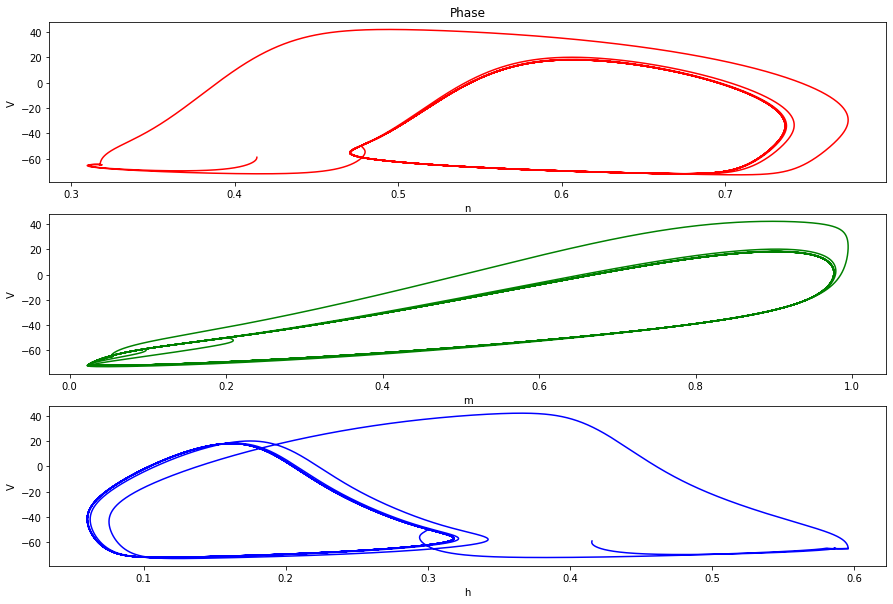

In [10]:
plot_phase_at_index(2)

Printing neuron values for times: [320, 520]


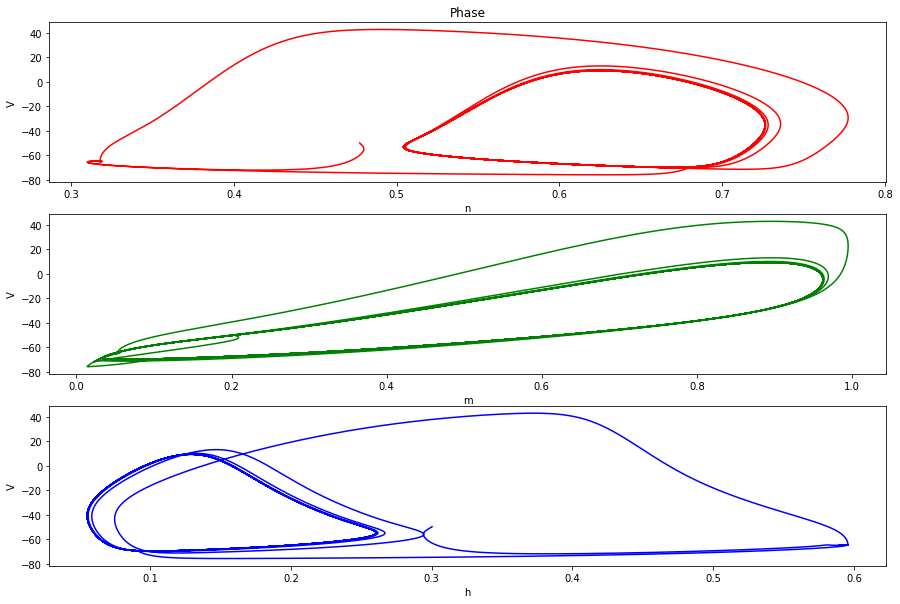

In [11]:
plot_phase_at_index(3)

## Simulation 2

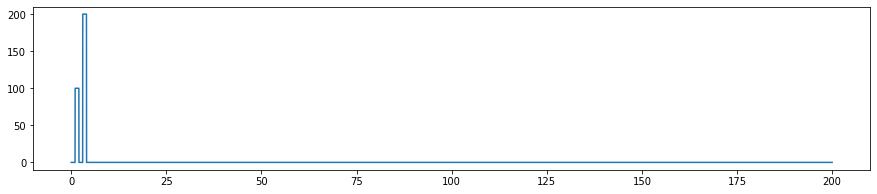

In [12]:
TIME_LIMIT = 200.0


def I2(t):
    if t < 1.0:
        return 0.0
    elif t < 2.0:
        return 100.0
    elif t < 3.0:
        return 0.0
    elif t < 4.0:
        return 200.0
    else:
        return 0.0


t = np.arange(0.0, TIME_LIMIT, 1e-3)
plt.figure(figsize=(15, 3))
plt.plot(t, list(map(I2, t)));

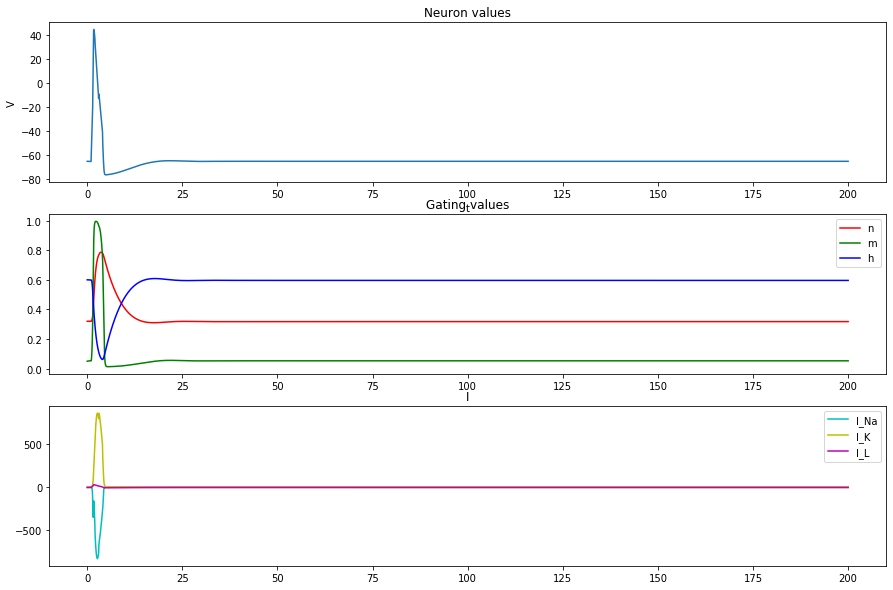

In [13]:
y = scipy_integrate.odeint(
    func=dy_dt,
    y0=Y_INITS,
    t=t,
    args=(I2,),
).T
plot(t, y)

## Simulation 3  = 1 + noise (Deadline task)

### Nonzero noise

In [39]:
def I31(t, low=0.0, high=1.0):
    value1 = I1(t)
    
    if value1 > 0:
        value1 += np.random.uniform(low=low, high=high)
    
    return value1

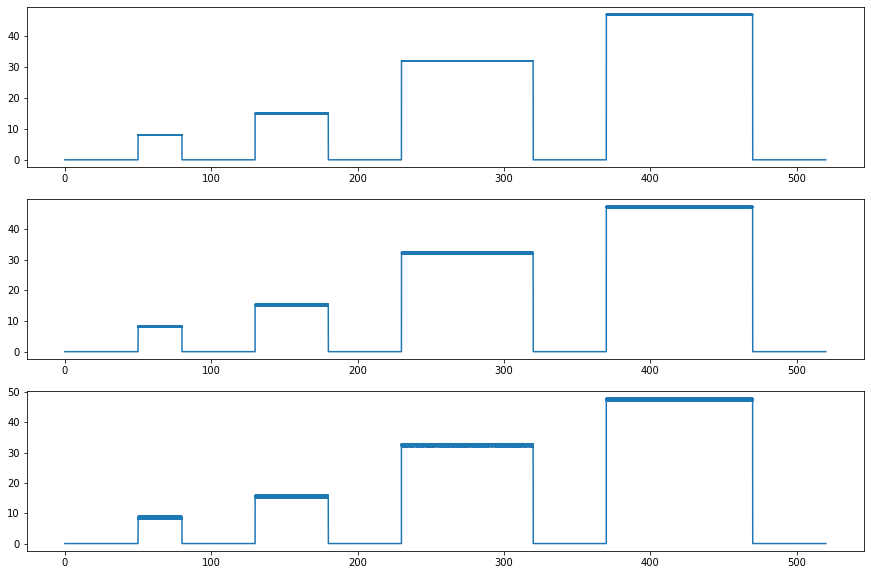

In [69]:
t = np.arange(0.0, time_limit1, 5e-3)
plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 1)
I = functools.partial(I31, low=0.0, high=0.1)
plt.plot(t, list(map(I, t)));
plt.subplot(3, 1, 2)
I = functools.partial(I31, low=0.0, high=0.5)
plt.plot(t, list(map(I, t)));
plt.subplot(3, 1, 3)
I = functools.partial(I31, low=0.0, high=1.0)
plt.plot(t, list(map(I, t)));

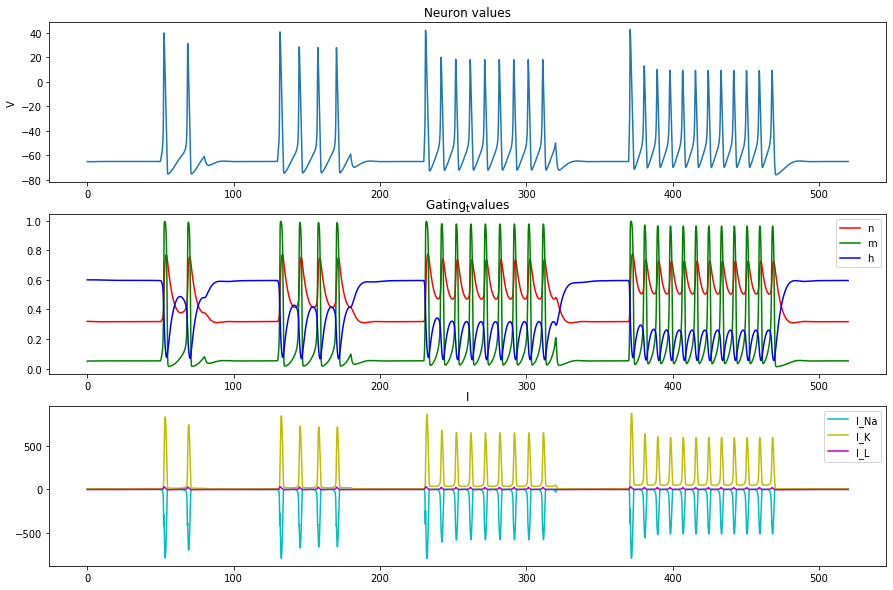

In [77]:
y = scipy_integrate.odeint(
    func=dy_dt,
    y0=Y_INITS,
    t=t,
    args=(functools.partial(I31, low=0.0, high=0.001),),
).T
plot(t, y)

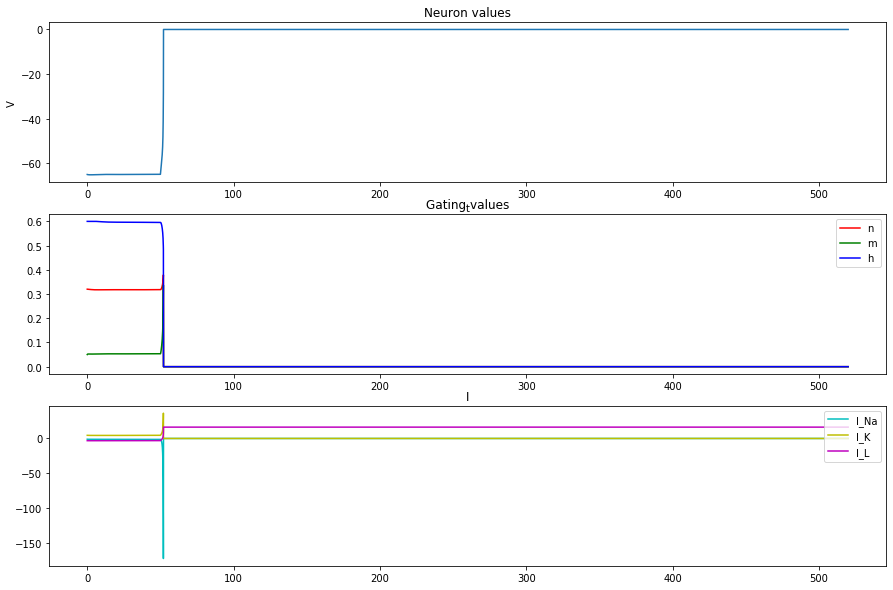

In [78]:
y = scipy_integrate.odeint(
    func=dy_dt,
    y0=Y_INITS,
    t=t,
    args=(functools.partial(I31, low=0.0, high=0.1),),
).T
plot(t, y)

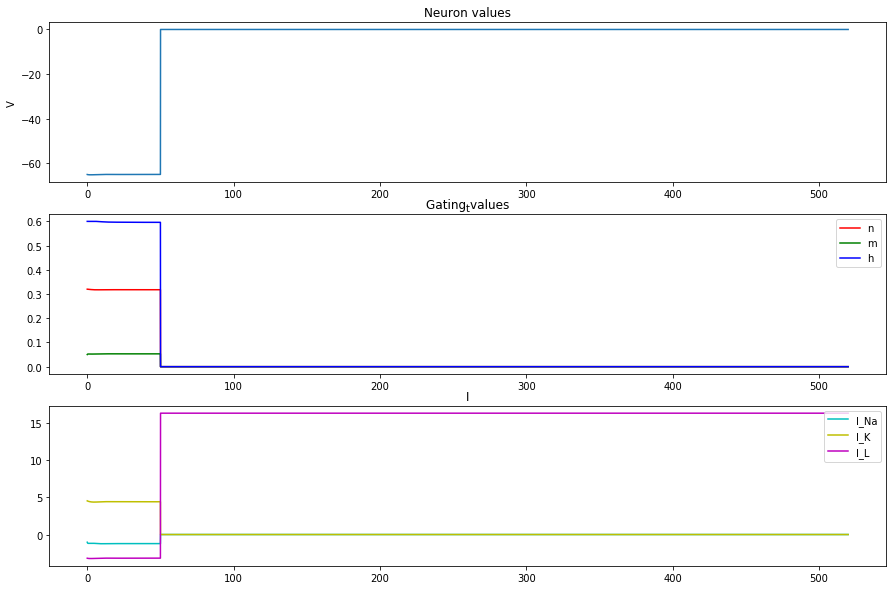

In [79]:
y = scipy_integrate.odeint(
    func=dy_dt,
    y0=Y_INITS,
    t=t,
    args=(functools.partial(I31, low=0.0, high=0.5),),
).T
plot(t, y)

### Zero noise

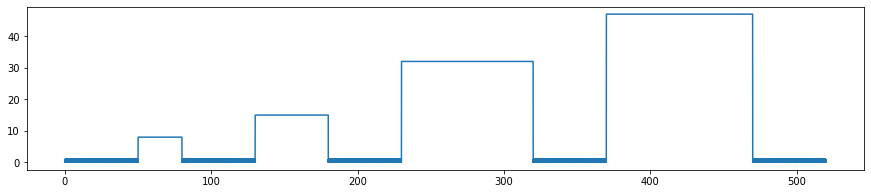

In [64]:
def I32(t, low=0.0, high=1.0):
    value1 = I1(t)
    
    if value1 == 0:
        value1 += np.random.uniform(low=low, high=high)
    
    return value1



t = np.arange(0.0, time_limit1, 5e-3)
plt.figure(figsize=(15, 3))
plt.plot(t, list(map(I32, t)));

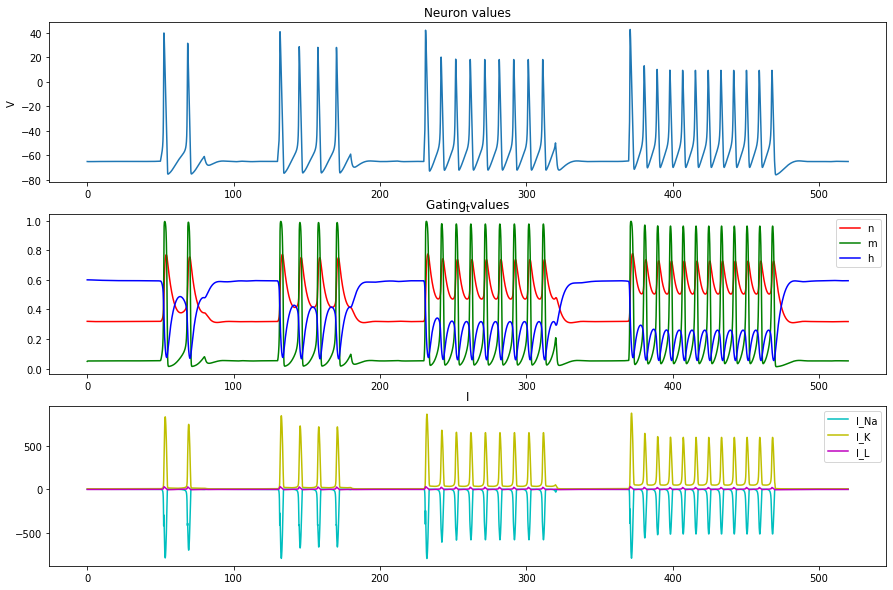

In [65]:
y = scipy_integrate.odeint(
    func=dy_dt,
    y0=Y_INITS,
    t=t,
    args=(functools.partial(I32, low=0.0, high=0.1),),
).T
plot(t, y)

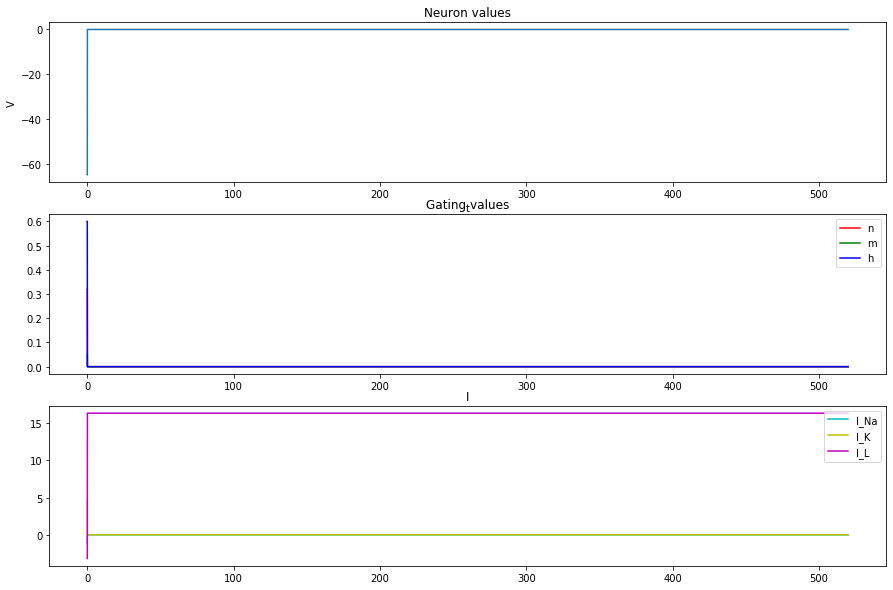

In [68]:
y = scipy_integrate.odeint(
    func=dy_dt,
    y0=Y_INITS,
    t=t,
    args=(functools.partial(I32, low=0.0, high=0.5),),
).T
plot(t, y)

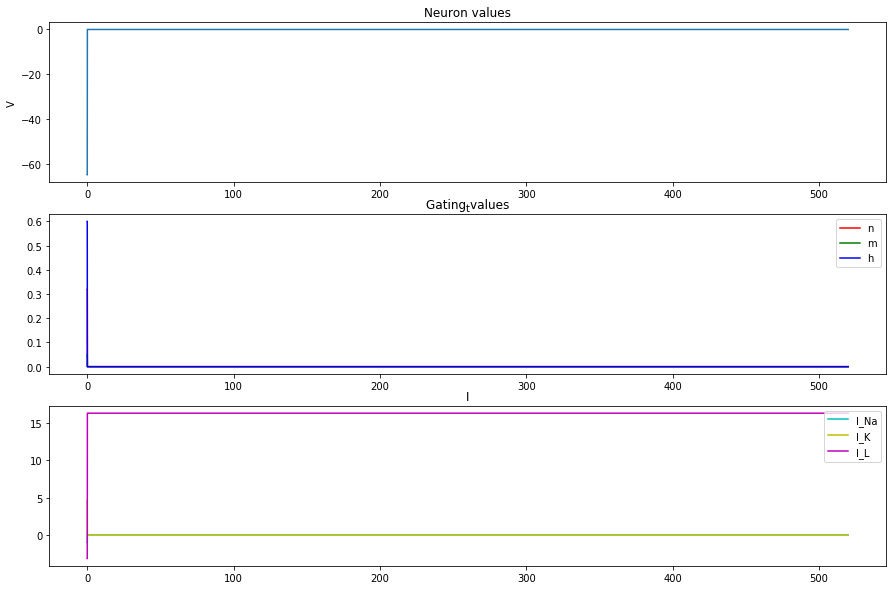

In [67]:
y = scipy_integrate.odeint(
    func=dy_dt,
    y0=Y_INITS,
    t=t,
    args=(functools.partial(I32, low=0.0, high=1.0),),
).T
plot(t, y)